# Ionized Species Inference Model Training (RandomForestClassifier)

Code for training the RandomForestClassifier to predict ionized species ([M+H]+, [M-H]-)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import joblib
import pandas as pd
import time
import scipy.stats as stats
from collections import Counter


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from skmultilearn.model_selection import iterative_train_test_split 

from IPython.display import display, clear_output
sys.path.append('./tools/')
from tools import tools

rTools=tools()



In [2]:
#File path definitions
modelEvalPath="./modelsAssessment/ionizedSpecies/"
MLModelsPath="./models/ionizedSpecies/"
trainingDataFile="./dataSets/ionizedSpecies/ionizedSpecies_trainingData_vd.pkl"


# **Data preprocessing**

In [3]:
# Loading of training data
data = joblib.load(trainingDataFile)
print(data["description"])
training_data=pd.concat([data['features'],data['target']], axis=1)
training_data



    This dataset contains information on the propensity of compounds to form 
    [M + H]+ or [M - H]- species under electrospray ionization (ESI) conditions.
  
    ================================   ==============
    Number of instances: 	 	10469
    Instances info: 	 		10469x1
    Features dimensionality: 	 	10469x217
    Features (Molecular descriptors): 	real, integers
    Target (Ionized species): 		bool
        	[M + H]+ (+H) (TRUE):	7641 - (FALSE):	2828
        	[M - H]- (-H) (TRUE):	5808 - (FALSE):	4661
    ================================   ==============

    Keys
    -------
        features : dataframe (10469, 217)
        target: dataframe (10469,2)
        feature_names: dataset column names.
        target_names: target labels names.
        instances_info: dataframe (10469 1) 
            SMILES
        description: str
            Full dataset description

    Notes
    -----
        - Ionized species labels (e.g., [M+H]⁺, [M–H]⁻) were compiled from in-house 
     

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,+H,-H
0,3.816036,3.816036,0.560326,0.560326,0.252201,45.000000,641.700,623.556,635.650873,108,...,0,0.000000,0.000000,10.513490,10.513490,50.342274,26.337726,-6.590764,False,True
1,9.131944,9.131944,1.217593,-1.217593,0.397283,5.400000,70.047,68.031,70.005479,26,...,0,0.000000,3.313053,3.313053,0.000000,7.947586,2.874414,0.808256,False,True
2,11.799684,11.799684,0.298750,-0.702503,0.809002,10.687500,256.132,245.044,255.021769,84,...,0,1.958360,1.764103,7.240585,3.518122,33.636723,13.493277,-4.085698,True,True
3,11.683982,11.683982,0.242803,-0.243241,0.787268,11.375000,236.702,223.598,236.071641,84,...,1,4.080092,1.755851,7.594280,1.758337,33.890309,16.699691,-2.657603,True,True
4,11.739132,11.739132,0.172003,-1.073379,0.592655,48.043478,310.437,284.229,310.193280,122,...,0,0.000000,3.545278,3.545278,0.000000,54.010618,26.951382,-3.105977,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10464,3.740741,3.740741,1.601852,1.601852,0.460096,8.000000,85.131,82.107,84.998620,26,...,0,1.937500,0.000000,3.875000,0.000000,11.010379,6.609621,-0.731531,True,False
10465,3.913843,3.913843,0.688657,0.688657,0.543761,10.222222,120.115,116.083,120.043596,44,...,0,8.089699,0.000000,8.089699,0.000000,15.417172,8.002828,-1.662631,True,True
10466,3.555556,3.555556,1.444444,1.444444,0.458207,8.000000,69.067,66.043,69.032697,26,...,0,5.812500,0.000000,5.812500,0.000000,8.640379,4.719621,-0.412202,True,True
10467,3.912037,3.912037,0.712963,0.712963,0.545467,10.222222,120.115,116.083,120.043596,44,...,0,8.089699,0.000000,8.089699,0.000000,15.417172,8.002828,-1.662631,True,False


In [4]:
training_data[['+H','-H']].apply(Counter)

+H    {False: 2828, True: 7641}
-H    {True: 4661, False: 5808}
dtype: object

# Preliminary Cleaning

In [5]:
exploring_data=training_data.copy()
exploring_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10469 entries, 0 to 10468
Columns: 219 entries, MaxAbsEStateIndex to -H
dtypes: bool(2), float64(113), int64(104)
memory usage: 17.4 MB


In [6]:
#Remove duplicate and null features
exploring_data_T_summary=exploring_data.describe().T
zero_vals=list(dict.fromkeys(list(exploring_data_T_summary[exploring_data_T_summary['count']==0].index)
+list(exploring_data_T_summary[exploring_data_T_summary['max']==0.0 ].index)
+list(exploring_data_T_summary[list(exploring_data_T_summary.duplicated(['mean','std','min','max']))].index)
    ))
exploring_data=exploring_data.drop(zero_vals,axis=1)
exploring_data.drop(columns=["+H","-H"]).columns.to_frame().to_csv(os.path.join(MLModelsPath,"IonizedSpecies_molecularDescriptors.vd.tsv"),sep="\t",index=False)
exploring_data

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,+H,-H
0,3.816036,0.560326,0.560326,0.252201,45.000000,641.700,623.556,635.650873,108,0,...,0,0.000000,0.000000,10.513490,10.513490,50.342274,26.337726,-6.590764,False,True
1,9.131944,1.217593,-1.217593,0.397283,5.400000,70.047,68.031,70.005479,26,0,...,0,0.000000,3.313053,3.313053,0.000000,7.947586,2.874414,0.808256,False,True
2,11.799684,0.298750,-0.702503,0.809002,10.687500,256.132,245.044,255.021769,84,0,...,0,1.958360,1.764103,7.240585,3.518122,33.636723,13.493277,-4.085698,True,True
3,11.683982,0.242803,-0.243241,0.787268,11.375000,236.702,223.598,236.071641,84,0,...,1,4.080092,1.755851,7.594280,1.758337,33.890309,16.699691,-2.657603,True,True
4,11.739132,0.172003,-1.073379,0.592655,48.043478,310.437,284.229,310.193280,122,0,...,0,0.000000,3.545278,3.545278,0.000000,54.010618,26.951382,-3.105977,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10464,3.740741,1.601852,1.601852,0.460096,8.000000,85.131,82.107,84.998620,26,0,...,0,1.937500,0.000000,3.875000,0.000000,11.010379,6.609621,-0.731531,True,False
10465,3.913843,0.688657,0.688657,0.543761,10.222222,120.115,116.083,120.043596,44,0,...,0,8.089699,0.000000,8.089699,0.000000,15.417172,8.002828,-1.662631,True,True
10466,3.555556,1.444444,1.444444,0.458207,8.000000,69.067,66.043,69.032697,26,0,...,0,5.812500,0.000000,5.812500,0.000000,8.640379,4.719621,-0.412202,True,True
10467,3.912037,0.712963,0.712963,0.545467,10.222222,120.115,116.083,120.043596,44,0,...,0,8.089699,0.000000,8.089699,0.000000,15.417172,8.002828,-1.662631,True,False


## Splitting the training dataset

In [7]:
labels=exploring_data[['+H','-H']]
exploring_data['idx']=range(0,len(exploring_data))
X_train, y_train, X_test, y_test = iterative_train_test_split(exploring_data.drop(columns=['+H','-H']).to_numpy(),
                                                              labels.to_numpy(), test_size = 0.25)
train_idxs=list(np.int16(X_train[:,-1]))
test_idxs=list(np.int16(X_test[:,-1]))
X_train=exploring_data.drop(columns=['idx','+H','-H']).iloc[train_idxs]
X_test=exploring_data.drop(columns=['idx','+H','-H']).iloc[test_idxs]
print("Training set:")
display(pd.DataFrame(y_train,columns=list(labels.columns)).apply(Counter))
print("Test set:")
display(pd.DataFrame(y_test,columns=list(labels.columns)).apply(Counter))
print("Complete dataset:")
display(labels.apply(Counter))

Training set:


+H    {False: 2120, True: 5731}
-H    {True: 3496, False: 4355}
dtype: object

Test set:


+H     {False: 708, True: 1910}
-H    {True: 1165, False: 1453}
dtype: object

Complete dataset:


+H    {False: 2828, True: 7641}
-H    {True: 4661, False: 5808}
dtype: object

# Building feature preprocessing functions

## Defining feature transformers

In [8]:
power_transformation=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
countFeatures=[feature for feature in list(X_train.columns) if feature.find("fr_")==0]+[feature for feature in list(X_train.columns) if feature.find("Num")>=0]+[feature for feature in list(X_train.columns) if feature.find("Coun")>=0]
realFeatures=list(set(X_train.columns)-set(countFeatures))

In [9]:
realNumerical_transformation_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy="median")),
        ("PowerTransform",power_transformation)
    ])

integerNumerical_transformation_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy="constant",fill_value=0)),
        ("PowerTransform",power_transformation)
    ])

In [10]:
preprocessing = ColumnTransformer([
    ("realStandarization",realNumerical_transformation_pipeline,realFeatures),
    ("integerStandarization",integerNumerical_transformation_pipeline,countFeatures)
],remainder='passthrough')

In [11]:
X_train_preprocesed=preprocessing.fit_transform(X_train)
X_train_preprocesed_df = pd.DataFrame(X_train_preprocesed, 
                                      columns=[featureName.split("__")[1] for featureName in preprocessing.get_feature_names_out()],
                                      index=train_idxs)
print(len(X_train_preprocesed_df))
display(X_train_preprocesed_df.head(5))

7851


,HallKierAlpha,MID_H,SlogP_VSA2,SMR_VSA2,MolLogP,Chi0v,BCUT2D_CHGLO,SlogP_VSA8,SlogP_VSA6,BCUT2D_LOGPLOW,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,HeavyAtomCount,NHOHCount,NOCount,RingCount
0,7.723149,0.013005,-0.087502,-0.160013,1.079291,0.752660,-0.331890,-0.585459,-1.729850,0.167959,...,-1.516251,0.119905,-1.920118,2.734808,-0.581359,1.290558,-0.322716,-1.497754,-3.582580,-0.505200
3,0.089405,-0.460422,-0.290553,-0.160013,-0.019418,-0.433672,-0.075963,-0.585459,-0.020853,-0.340272,...,-0.285583,-0.484985,-0.584958,-0.365003,-0.581359,-0.683713,-0.543449,-0.365764,-0.689315,-0.505200
4,0.413633,-1.483775,-0.674906,-0.160013,0.204405,0.174316,-1.779783,-0.585459,-0.040780,-1.061754,...,-0.285583,-1.439466,-1.055264,2.745304,-0.581359,1.599058,0.128305,-0.365764,-1.246491,1.063018
6,0.682287,-1.487761,-0.674906,-0.160013,0.264543,0.233450,-1.900672,-0.585459,-0.650134,-1.075735,...,-0.285583,-1.439466,-1.920118,2.745665,-0.581359,1.696598,0.128305,-0.365764,-1.246491,1.063018
9,0.215090,-0.829363,-0.712705,-0.160013,0.355369,0.330098,-1.894860,1.608493,-0.392968,-1.084393,...,-0.285583,-0.896478,-1.920118,2.745665,-0.581359,1.696598,0.278998,-0.365764,-0.689315,1.401360


## Feature dimensionality reduction

90 PCs explaining 95.2% of the total variance


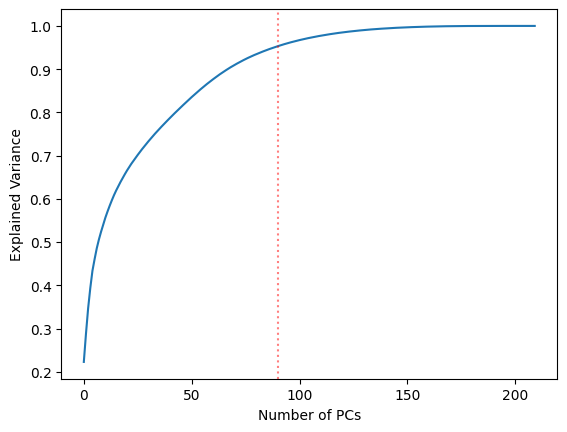

In [12]:
pca = PCA()
X_20D=pca.fit_transform(X_train_preprocesed_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)
plt.axvline(x=d,color='red',linestyle = ':', alpha = 0.5,linewidth=1.5)
plt.xlabel(r"Number of PCs")
plt.ylabel(r"Explained Variance")
print(f"{d} PCs explaining {round(pca.explained_variance_ratio_[0:d].sum()*100,1)}% of the total variance")

In [13]:
pcaTransform = PCA(n_components=0.95)
X_pcaTranformed=pcaTransform.fit_transform(X_train_preprocesed)

In [14]:
# Save preprocessing transformers for model deployment
joblib.dump(preprocessing, os.path.join(MLModelsPath,"IonizedSpecies_columnsTransformers.vd.joblib"))
joblib.dump(pcaTransform, os.path.join(MLModelsPath,"IonizedSpecies_pcaTransformer.vd.joblib"))

['./models/ionizedSpecies/IonizedSpecies_pcaTransformer.vd.joblib']

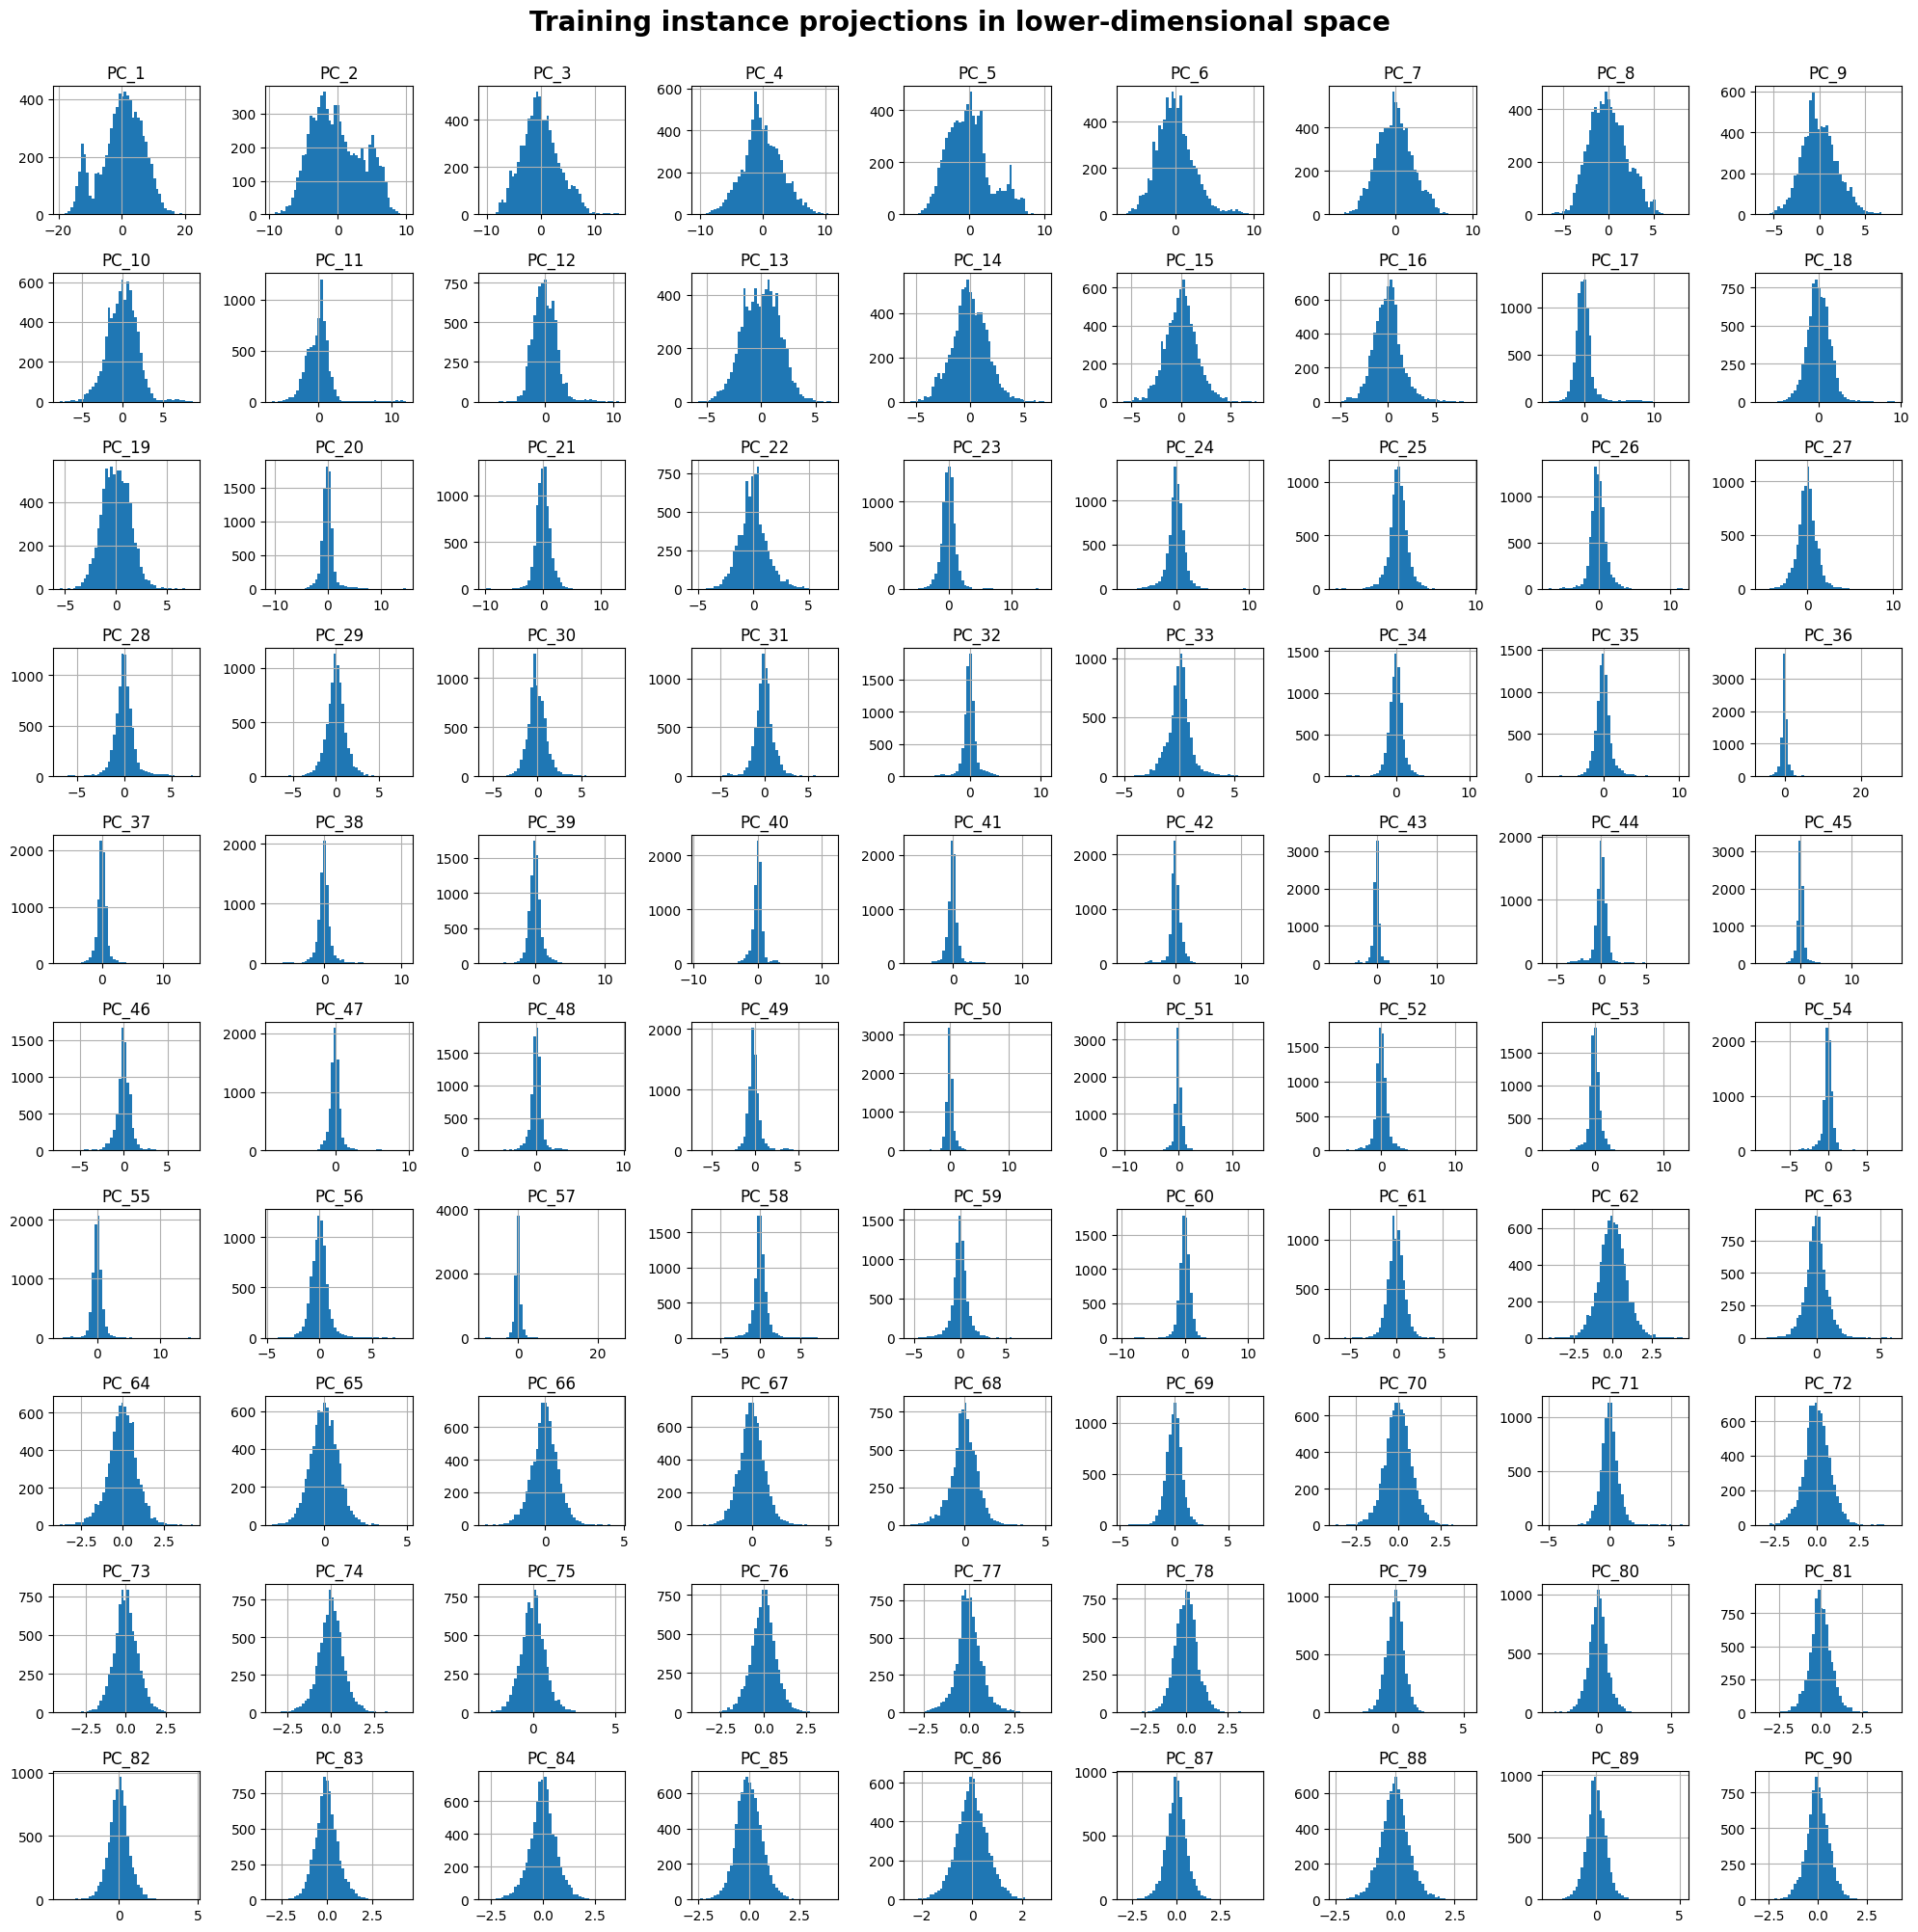

In [15]:
trainigDataFullTransformed=pd.DataFrame(X_pcaTranformed,columns=["PC_"+str(i+1) for i in range(0,np.shape(X_pcaTranformed)[1])])
trainigDataFullTransformed_names=list(trainigDataFullTransformed.columns)
plt_transf=trainigDataFullTransformed.hist(bins=50,figsize=(20,20))
plt.suptitle(r"Training instance projections in lower-dimensional space",fontweight='bold',size=20,y=1.0)
plt.tight_layout() 
plt.show()

# **RandomForestClassifier Hyperparameter Optimization and Model Fitting**

In [16]:
X_train_transformed=X_pcaTranformed

In [17]:
# Random Forest Classifier hyperparameter optimization by grid search

isHyperparameterOpt=False
  
if isHyperparameterOpt:
    ionizedSpeciesClassifier=RandomForestClassifier()  
    grid_parameters=[{"n_estimators":[50,100,150,200,250],
                      "max_features":[1.0,0.75,0.5,0.25,0.1],
                      'criterion': ['gini', 'entropy'],
                      'max_depth':[10, 20, 30, 40],
                      'ccp_alpha':[0.00,0.005,0.01, 0.05],
                      'random_state':[42]
                     }]



    startTime = time.monotonic()
    grid_search=GridSearchCV(ionizedSpeciesClassifier, 
                             grid_parameters,
                             cv=5,
                             scoring=None,
                             n_jobs=6,
                             return_train_score=True)

    grid_search.fit(X_train_transformed,y_train)
    elapsed_time = time.monotonic() - startTime
    print(f"Grid search elapsed time: {round(elapsed_time,2)} s")
    print(f"Best parameters: {grid_search.best_params_}\n")
    pd.DataFrame(grid_search.cv_results_).to_csv(os.path.join(modelEvalPath,"hp_searchResults_RF_model_ionizedSpecies.vd.tsv"),sep="\t",index=False)
    pd.DataFrame.from_dict(grid_search.best_params_, orient='index').to_csv(os.path.join(modelEvalPath,"hp_optimalParameters_RT_model_ionizedSpecies.vd.tsv"),sep="\t",index=True)
    print(f"Best score: {grid_search.best_score_}")

    #The optimal hyperparameters obtained through grid search are::
    __best_n_estimators=grid_search.best_params_['n_estimators']
    __best_max_features=grid_search.best_params_['max_features']
    __best_max_depth=grid_search.best_params_['max_depth']
    __best_criterion=grid_search.best_params_['criterion']
    __best_ccp_alpha=grid_search.best_params_['ccp_alpha']
else:
     #Best parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 20, 
     #                  'max_features': 1.0, 'n_estimators': 100, 'random_state': 42}
    __best_n_estimators=100
    __best_max_features=1.0
    __best_max_depth=20
    __best_criterion='entropy'
    __best_ccp_alpha=0.0




## **Model fitting using optimal hyperparameters**

In [18]:
ionizedSpeciesClassifier=RandomForestClassifier(max_features=__best_max_features,
                                                n_estimators=__best_n_estimators,
                                                criterion=__best_criterion,
                                                max_depth=__best_max_depth,
                                                ccp_alpha=__best_ccp_alpha,
                                                n_jobs=6,
                                                random_state=42)
ionizedSpeciesClassifier.fit(X_train_transformed,y_train)


RandomForestClassifier(criterion='entropy', max_depth=20, max_features=1.0,
                       n_jobs=6, random_state=42)

# **Model performance assessment**


## **Training Set Performance Assessment**

In [19]:
cv=rTools.kFoldsMultilabelSplit(train_idxs,labels,k_folds=10,test_size=0.2,rand_seed=100)
trainingScores=rTools.getMultilabelCrossValidationTrainingScores(ionizedSpeciesClassifier,X_train_transformed,y_train,
                                                                   classifierslabels=["+H","-H"],
                                                                   multilabelSplit=cv)
trainingScores.to_csv(os.path.join(modelEvalPath,"crossValidationResults_ionizedSpecies_model_RF.vd.tsv"),sep="\t",index=False)
trainingScores

,score,mean,std,U,n,data,label
0,Accuracy,88.6378,0.934985,0.668848,10.0,"[90.388, 87.524, 87.715, 89.115, 88.351, 88.54...",+H
1,Recall(0),68.5412,2.790661,1.996319,10.0,"[73.176, 65.176, 66.118, 70.588, 70.824, 66.82...",+H
2,Precision(0),86.6898,2.044219,1.462346,10.0,"[89.368, 85.231, 85.152, 86.705, 83.611, 87.92...",+H
3,F_1(0),76.5276,2.139333,1.530386,10.0,"[80.466, 73.866, 74.437, 77.821, 76.688, 75.93...",+H
4,Recall(1),96.0908,0.666673,0.476909,10.0,"[96.771, 95.812, 95.724, 95.986, 94.852, 96.59...",+H
5,Precision(1),89.1799,0.865864,0.619402,10.0,"[90.679, 88.122, 88.396, 89.796, 89.761, 88.70...",+H
6,F_1(1),92.5038,0.600465,0.429547,10.0,"[93.626, 91.806, 91.914, 92.788, 92.236, 92.48...",+H
7,MCC,0.700192,0.025929,0.018548,10.0,"[0.7482699231514202, 0.6688525464710587, 0.674...",+H
8,AUCIMCP,0.71954,0.008773,0.006276,10.0,"[0.7406713922835984, 0.712789398426223, 0.7105...",+H
9,AUCROC,0.939906,0.007905,0.005655,10.0,"[0.9543558217999999, 0.9391365063499999, 0.930...",+H


## **Test-set performance assessment**

In [20]:
X_test_transformed=pcaTransform.transform(preprocessing.transform(X_test))

In [21]:
y_test_pred_prob=ionizedSpeciesClassifier.predict_proba(X_test_transformed)
cfMtxs_test=rTools.getMultiLabelContingenceMatrix(y_test_pred_prob,y_test)
rTools.joinContingenceMatrices(cfMtxs_test,["+H","-H"]).to_csv(os.path.join(modelEvalPath,"confMtx_test_ionizedSpecies_model_RF.vd.tsv"),sep="\t")
print(r"Ioned specie: [M + H]+")
display(cfMtxs_test[0])
print(r"Ioned specie: [M - H]-")
display(cfMtxs_test[1])

Ioned specie: [M + H]+


target,0,1,label
prediction,,,
0,574,113,+H
1,134,1797,+H


Ioned specie: [M - H]-


target,0,1,label
prediction,,,
0,1315,296,-H
1,138,869,-H


In [22]:
mByPThres=rTools.getMetricsAtProbabilityThreshold(y_test_pred_prob,y_test,["+H","-H"],pThres=0.5)
mByPThres

,Accuracy,Recall(0),Precision(0),F_1(0),Recall(1),Precision(1),F_1(1),MCC,Prob(0),Prob(1),label
0,90.565,81.073,83.552,82.294,94.084,93.061,93.570,0.758813,0.5,0.5,+H
1,83.422,90.502,81.626,85.835,74.592,86.296,80.018,0.664934,0.5,0.5,-H


In [23]:
y_test_=exploring_data[['+H','-H']].copy().iloc[test_idxs].reset_index(drop=True)
testStats=rTools.getMultilabelTestMetricsStatistics(X_test.reset_index(drop=True),y_test_,
                                                      inputPreprocessing=preprocessing,
                                                      inputTransformation=pcaTransform,
                                                      inputModel=ionizedSpeciesClassifier,
                                                      n_folds=10,selectedProb=[0.5,0.5],rand_seed=42,
                                                      mainAndComplementaryClasses=['Recall(1)','Recall(0)'])
testStats.to_json(os.path.join(modelEvalPath,"allMetrics_test_ionizedSpecies_model_RF.vd.json"))


In [24]:
maxProbMetrics=rTools.getMetricsAverages(testStats,"maxValsMetrics")
maxProbMetrics.to_csv(os.path.join(modelEvalPath,"metrics_test_ionizedSpecies_model_RF.vd.tsv"),sep="\t",index=False)
maxProbMetrics

,score,mean,std,U,n,label
0,Accuracy,90.5652,0.77337,0.553236,10.0,+H
1,Recall(0),81.0735,1.614311,1.154808,10.0,+H
2,Precision(0),83.5812,1.905648,1.363219,10.0,+H
3,F_1(0),82.296,1.405474,1.005415,10.0,+H
4,Recall(1),94.0837,0.79479,0.568558,10.0,+H
5,Precision(1),93.0627,0.56127,0.401509,10.0,+H
6,F_1(1),93.5686,0.535994,0.383427,10.0,+H
7,MCC,0.758945,0.019398,0.013877,10.0,+H
8,Accuracy,83.4224,0.528185,0.37784,10.0,-H
9,Recall(0),90.5026,0.901193,0.644675,10.0,-H


In [25]:
AUCs_averages=rTools.getAUCsAverages(testStats)
AUCs_averages.to_csv(os.path.join(modelEvalPath,"AUCs_test_IonizedSpecies_model_RF.vd.tsv"),sep="\t",index=False)
AUCs_averages

,score,mean,std,U,n,label
0,AUC(IMCP),0.754154,0.007389,0.005286,10.0,+H
1,AUC(ROC),0.948894,0.004237,0.003031,10.0,+H
2,AUC(PRC),0.97656,0.001999,0.00143,10.0,+H
3,AUC(IMCP),0.682248,0.005482,0.003922,10.0,-H
4,AUC(ROC),0.917426,0.004983,0.003564,10.0,-H
5,AUC(PRC),0.903384,0.005676,0.00406,10.0,-H


In [26]:
PRCs_averaged=rTools.getAveragePRC(testStats)
PRCs_averaged.to_csv(os.path.join(modelEvalPath,"PRCs_test_IonizedSpecies_model_RF.vd.tsv"),sep="\t",index=False)

In [27]:
cfMtxs_test[0].iloc[:,0:2]

target,0,1
prediction,,
0,574,113
1,134,1797


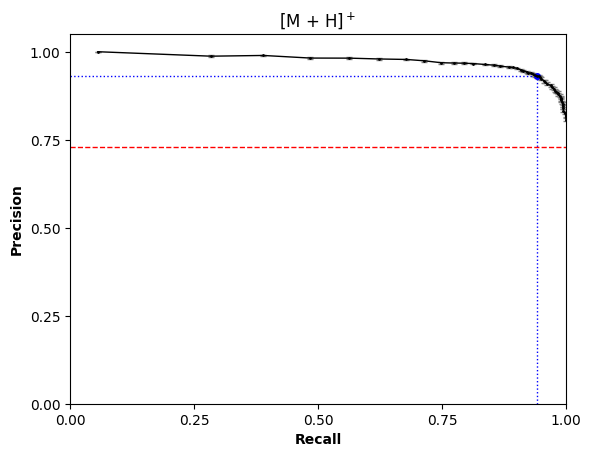

In [28]:
PRCs_averagedHp=PRCs_averaged[PRCs_averaged.label=="+H"].reset_index(drop=True)
maxProbMetrics_=maxProbMetrics[maxProbMetrics.label=="+H"]
precision=maxProbMetrics_[maxProbMetrics_.score=="Precision(1)"]['mean'].iloc[0]/100
recall=maxProbMetrics_[maxProbMetrics_.score=="Recall(1)"]['mean'].iloc[0]/100
lprec=cfMtxs_test[0].iloc[:,1].sum()/cfMtxs_test[0].iloc[:,0:2].sum().sum()
plt.errorbar(PRCs_averagedHp.Recall_mean,PRCs_averagedHp.Precision_mean, yerr=PRCs_averagedHp.Precision_U,
            fmt='-o',markersize=1.0,linewidth=1,capsize=2, color='black', ecolor='gray', elinewidth=0.5, markerfacecolor='black')

plt.title(r"[M + H]$^+$")

plt.xlabel(r'Recall',fontweight='bold')
plt.ylabel(r'Precision',fontweight='bold')
plt.hlines(precision, xmin=0.0, xmax=recall, colors='blue', linestyles=':', linewidth=1.)
plt.vlines(recall, ymin=0.0, ymax=precision, colors='blue', linestyles=':', linewidth=1.)
plt.plot([recall], [precision], marker='o', color='blue', markersize=4)
plt.hlines(lprec, xmin=0.0, xmax=1., colors='red', linestyles='--', linewidth=1.)
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xticks(list(np.arange(0.0,1.05,0.25)))
plt.yticks(list(np.arange(0.0,1.05,0.25)))
plt.show()


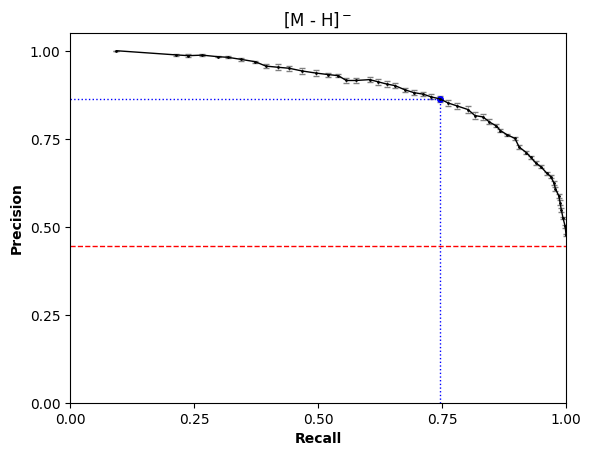

In [29]:
PRCs_averagedHp=PRCs_averaged[PRCs_averaged.label=="-H"].reset_index(drop=True)
maxProbMetrics_=maxProbMetrics[maxProbMetrics.label=="-H"]
precision=maxProbMetrics_[maxProbMetrics_.score=="Precision(1)"]['mean'].iloc[0]/100
recall=maxProbMetrics_[maxProbMetrics_.score=="Recall(1)"]['mean'].iloc[0]/100
lprec=cfMtxs_test[1].iloc[:,1].sum()/cfMtxs_test[1].iloc[:,0:2].sum().sum()
plt.errorbar(PRCs_averagedHp.Recall_mean,PRCs_averagedHp.Precision_mean, yerr=PRCs_averagedHp.Precision_U,
            fmt='-o',markersize=1.0,linewidth=1,capsize=2, color='black', ecolor='gray', elinewidth=0.5, markerfacecolor='black')

plt.title(r"[M - H]$^-$")

plt.xlabel(r'Recall',fontweight='bold')
plt.ylabel(r'Precision',fontweight='bold')
plt.hlines(precision, xmin=0.0, xmax=recall, colors='blue', linestyles=':', linewidth=1.)
plt.vlines(recall, ymin=0.0, ymax=precision, colors='blue', linestyles=':', linewidth=1.)
plt.plot([recall], [precision], marker='o', color='blue', markersize=4)
plt.hlines(lprec, xmin=0.0, xmax=1., colors='red', linestyles='--', linewidth=1.)
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xticks(list(np.arange(0.0,1.05,0.25)))
plt.yticks(list(np.arange(0.0,1.05,0.25)))
plt.show()

# **Final model fitting using all training data**

In [30]:
X_allData=exploring_data.copy().drop(columns=['+H','-H','idx'])
y_allData=exploring_data[['+H','-H']].copy().to_numpy()
X_allData_transformed=pcaTransform.transform(preprocessing.transform(X_allData))
ionizedSpeciesClassifier_final=RandomForestClassifier(max_features=__best_max_features,
                                                n_estimators=__best_n_estimators,
                                                criterion=__best_criterion,
                                                max_depth=__best_max_depth,
                                                ccp_alpha=__best_ccp_alpha,
                                                n_jobs=6,
                                                random_state=42)
ionizedSpeciesClassifier_final.fit(X_allData_transformed,y_allData)
joblib.dump(ionizedSpeciesClassifier_final, os.path.join(MLModelsPath,"ionizedSpecies_RF_model.vd.joblib"))

['./models/ionizedSpecies/ionizedSpecies_RF_model.vd.joblib']